# Собственный класс градиентного бустинга и его применение на датасете игроков FIFA Ultimate Team


In [11]:
import tqdm
import numpy as np
from scipy.special import expit as sigmoid
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

## Часть 1. Реализация градиентного бустинга

### 1. Функции потерь

Начнем с функций потерь. Нам нужны будут две функции потерь, одна для задачи классификации и одна для задачи регрессии. Для каждой из них напишем отдельный класс, который позволит вычислять как саму функцию потерь, так и ее градиент.

#### 1.1. Базовый класс Loss

Сначала напишем базовый класс `Loss`, от которого будем наследоваться при написании функций потерь.
Вычисление значения функции потерь будет производиться в методе `forward`, а градиента - в методе `backward`.

Метод `forward` должен получать на вход два вектора: вектор целевых переменных и вектор предсказаний модели.
Метод должен: 
* проверять, что длины векторов совпадают (с помощью `assert`)
* возвращать вектор той же длины, содержащий значения функции потерь для каждого из объектов

Метод `grad` должен делать то же самое, но возвращать значение градиента функции потерь.

In [1]:
class Loss(object):
    
    def __call__(self, y, p):
        """
        Call and use .forward()
        :param y: array-like targets
        :param p: array-like predictions
        :return array-like loss values
        """
        return self.forward(y, p)
        
    def forward(self, y, p):
        """
        Calculate loss value
        :param y: array-like targets
        :param p: array-like predictions
        :return array-like loss values
        """
        raise NotImplementedError
        
    def grad(self, y, p):
        """
        Calculate grad value
        :param y: array-like targets
        :param p: array-like predictions
        :return array-like grad values
        """
        raise NotImplementedError

#### 1.2. Функция потерь для задачи регрессии (MSE)

Для задачи регрессии будем использовать `Mean Squared Error (MSE)`:

$$L = MSE(y,p) = \frac{1}{2n}(y - p) ^ 2$$

Ее градиент:
$$\frac{\partial L}{\partial p} = \frac{1}{n}(p - y)$$

В формулах выше `p` - предсказания модели.

In [13]:
class MSELoss(Loss):
    
    def forward(self, y, p):
        assert len(y) == len (p), '%s is not the same length as %s'% (y, p)
        return 0.5 / len(y) * (y - p) ** 2
    
    def grad(self, y, p):
        assert len(y) == len (p), '%s is not the same length as %s'% (y, p)
        return (p - y) #не делю на n, так как ухудшает сходимость!

Для проверки корректности своего кода используйте ячейку ниже.

*Код в ячейках ниже должен выполняться без ошибок.*

In [14]:
mse_loss = MSELoss()

ys = np.array((10, 20, 30))
ps = np.array((5, 25, 30))

np.testing.assert_raises(AssertionError, mse_loss, np.asarray([1, 2, 3]), np.asarray([1, 2, 3, 4, 5]))
np.testing.assert_raises(AssertionError, mse_loss.grad, np.asarray([1, 2, 3]), np.asarray([1, 2, 3, 4, 5]))

np.testing.assert_almost_equal(mse_loss(ys, ps), np.asarray([4.16667, 4.1666, 0]), decimal=4)
np.testing.assert_almost_equal(mse_loss.grad(ys / len(ys), ps / len(ps)), np.asarray([-1.66667, 1.66667, 0]), decimal=4)

Если ошибок нет, можно переходить к следующей части.

#### 1.3. Функция потерь для задачи классификации (BCE)

Для задачи регрессии будем использовать `Binary Cross-Entropy (BCE)`:
$$L = BCE(y,p) = \frac{1}{n}(-y \log{p} - (1-y)\log{(1-p)})$$

Ее градиент по `p`:
$$\frac{\partial L}{\partial p} = \frac{(p - y)}{p(1-p)}$$

Вспомним, что для вычисления `p` используется сигмоида:
$$p = \sigma (z) = \frac{1}{1 + \exp (-z)}$$
$$\sigma (z)' = \sigma (z) (1 - \sigma (z))$$

Подставив последнее выражение в градиент функции потерь, получим аналогичное `MSE` выражение:
$$\frac{\partial L}{\partial z} = \frac{1}{n}(z - y)$$

В формулах выше `z` - предсказания модели до применения сигмоиды, `p` - после.

**Важно:** для дальнейшего удобства методы `forward` и `grad` в качестве предсказаний должны получать `z`, **активации** модели, то есть результат вычислений модели без взятия сигмоиды от них; сигмоидальное преобразования реализуется внутри этих методов (см.код).

**Важно:** не забудьте при вычислении логарифмов добавить отсечку значений аргумента значениями (`eps`, 1 - `eps`) в избежание ошибок арифметики.

In [15]:
class BCEWithLogitsLoss(Loss):
    


    def forward(self, y, z):
        eps = 1e-5
        p = sigmoid(z)
        assert len(y) == len (p), '%s is not the same length as %s'% (y, p)
        p[p <= 0] = eps
        p[p >= 1] = 1 - eps
        return - 1 / len(y) * (y * np.log(p) + (1 - y) * np.log(1-p))
    
    def grad(self, y, z):
        eps = 1e-5
        p = sigmoid(z)
        assert len(y) == len (p), '%s is not the same length as %s'% (y, p)
        p[p <= 0] = eps
        p[p >= 1] = 1 - eps
        return (p - y) / len(y)

Для проверки корректности своего кода используйте ячейку ниже.

*Код в ячейках ниже должен выполняться без ошибок.*

In [16]:
bce_loss = BCEWithLogitsLoss()

ys = np.array((1, 0, 0))
zs = np.array((0.0, 100.0, 1.0))

np.testing.assert_raises(AssertionError, bce_loss, np.asarray([1, 2, 3]), np.asarray([1, 2, 3, 4, 5]))
np.testing.assert_raises(AssertionError, bce_loss.grad, np.asarray([1, 2, 3]), np.asarray([1, 2, 3, 4, 5]))

np.testing.assert_array_less(bce_loss(ys, zs), np.inf)

np.testing.assert_almost_equal(bce_loss(ys, zs), np.asarray([0.231 , 3.8376, 0.4378]), decimal=4)
np.testing.assert_almost_equal(bce_loss.grad(ys, zs), np.asarray([-0.1667,  0.3333,  0.2437]), decimal=4)

Если ошибок нет, можно переходить к следующей части.

### 2. Градиентный бустинг

#### 2.1. Класс GradentBoosting
После того, как были получены классы для функций потерь, можно приступать к реализации класса для градиентного бустинга `GradientBoosting`.
В качестве базовых моделей будем использовать деревья решений (`DecisionTreeRegressor` из `sklearn.tree`).
Итоговый вид композиции:
$$a(x) = \sum_{t=1}^{T}\eta * b_{t}(x)$$

Параметры класса (аргументы метода `__init__()`):
* `loss`: объект одного из двух классов, реализованных выше (`MSELoss` или `BCELoss`), будет определять поведение при вызове метода `predict()`.
* `n_estimators`: число деревьев `T` (итераций бустинга)
* `learning_rate`: темп обучения (коэффициент $\eta$)
* `max_depth`: максимальная глубина построенных деревьев (параметр `DecisionTreeRegressor`)
* `max_features`: число признаков для поиска наилучшего разбиения в узле (параметр `DecisionTreeRegressor`)

В методе `__init__()` создаются списки для хранения отдельных деревьев (`self.estimators`) и значений функции потерь на каждом шаге (`self.loss_values`).
Также имеется дополнительное поле `self.loss_values_evalset`, в котором можно хранить значения функции потерь на отложенной (`evalset`) выборке по итерациям.

Метод `fit(X, y, X_eval=None, y_eval=None)` должен:
* Инициализировать "нулевое приближение" средним значением целевой переменной, считать значение потерь при нем
* Итерируясь по числу деревьев:
  * Вычислять **антиградиент** функции потерь построенной композиции по каждому объекту (остатки), создавать новое дерево, обучать его на полученных остатках и добавлять в список деревьев.
  * Вычислять новое значение предсказания композиции для обучающей выборки (добавлением ответов нового дерева с весом $\eta$)
  * Считать новое значение функции потерь (суммарно по всем объектам) и добавлять в список
* В случае, если методу передаются также `X_eval` и `y_eval`, нужно вычислять значение функции потерь на этом множестве на каждой итерации.
  
Метод `predict(X)` должен:
* Для каждого объекта из `X` делать предсказание с помощью всех деревьев композиции  (**не забывайте про "нулевое приближение"**) и суммировать их
* Если решается задача классификации, применять сигмоиду на полученных ответах

In [17]:
class GradientBoosting(BaseEstimator):
    
    def __init__(self, 
                 loss=None,
                 n_estimators=10, 
                 learning_rate=0.1,
                 max_depth=3,
                 max_features='auto',
                 random_state=2):
        self.loss = loss
        
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        
        self.max_depth = max_depth
        self.max_features = max_features
        
        self.estimators = []
        self.loss_values = []
        self.loss_values_evalset = []
        
        self.random_state = random_state
    
    def fit(self, X_train, y_train, X_evalset=[], y_evalset=[], verbose=False, patience=3, decrease_treshold=0.001): 
        iter_prediction = np.array([y_train.mean() for i in range (len(y_train))])
        iter_loss = self.loss.forward(y_train, iter_prediction)
        self.loss_values.append(iter_loss.sum())
        self.estimators.append(iter_prediction)
        if len(y_evalset) != 0:
            iter_prediction_eval = np.array([y_evalset.mean() for i in range (len(y_evalset))])
        for t in range(1, self.n_estimators):
            antigradient = - self.loss.grad(y_train, iter_prediction)
            tree = DecisionTreeRegressor (max_depth=self.max_depth, \
                                          max_features=self.max_features, \
                                          random_state=self.random_state). \
                                        fit(X_train, antigradient)
            self.estimators.append(tree)
            iter_prediction += self.learning_rate * tree.predict(X_train)
            iter_loss = self.loss.forward(y_train, iter_prediction)
            self.loss_values.append(iter_loss.sum())
            if verbose == True and t % 10 == 0:
                print ('Iter # %s:' %t, 'Loss value: %s' %self.loss_values[-1])
            if len(y_evalset) != 0:
                iter_prediction_eval += tree.predict(X_evalset)
                iter_loss_eval = self.loss.forward(y_evalset, iter_prediction_eval)
                self.loss_values_evalset.append(iter_loss_eval.sum())
                if t % 10 == 0 and verbose == True:
                    print('Loss on evalset: %s' %self.loss_values_evalset[-1])
    
    def predict(self, X):
        #prediction = self.estimators[0][:X.shape[0]]
        prediction = np.zeros(X.shape[0])
        for tree in self.estimators[1:]:
            prediction += self.learning_rate * tree.predict(X)
        return prediction
        

#### 2.2. Тестирование класса GradientBoosting

##### 2.2.1. Интерфейс
*Код в ячейках ниже должен выполняться без ошибок.*

In [18]:
X_test = np.random.uniform(size=(100, 2))
y_test = np.random.uniform(size=100)

gb_test = GradientBoosting(loss=MSELoss(), n_estimators=100)
gb_test.fit(X_test, y_test)

In [19]:
assert len(gb_test.estimators) == gb_test.n_estimators
assert gb_test.predict(X_test).shape == y_test.shape

Сгенерируем случайную выборку и убедимся, что функция потерь уменьшается при увеличении итераций.

*Код в ячейках ниже должен выполняться без ошибок.*

##### 2.2.2. Регрессия

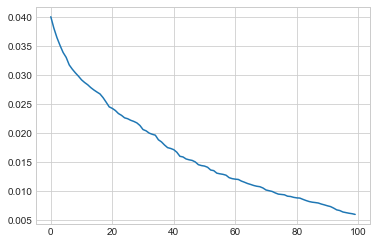

In [20]:
X_test = np.random.uniform(size=(100, 2))
y_test = np.random.uniform(size=100)

gb_test = GradientBoosting(loss=MSELoss(), n_estimators=100)
gb_test.fit(X_test, y_test)

loss_values = gb_test.loss_values
plt.plot(loss_values)
np.testing.assert_array_equal(loss_values, sorted(loss_values, reverse=True))

##### 2.2.3. Классификация

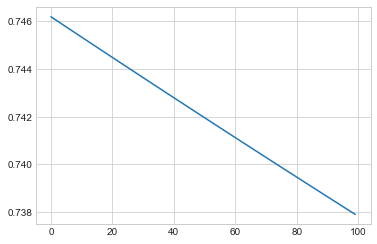

In [21]:
X_test = np.random.uniform(size=(100, 2))
y_test = np.random.binomial(1, 0.5, size=100)

gb_test = GradientBoosting(loss=BCEWithLogitsLoss(), n_estimators=100)
gb_test.fit(X_test, y_test)

loss_values = gb_test.loss_values
plt.plot(loss_values)
np.testing.assert_array_equal(loss_values, sorted(loss_values, reverse=True))

### 3. Использование класса GradientBoosting

Проверим, как работает наш бустинг на двух задачах - регрессии и классификации на 2 класса.
Для этого будем использовать игрушечные выборки, полученные с помощью `sklearn.datasets.make_regression` и `sklearn.datasets.make_classificaiton`.

In [22]:
from sklearn.metrics import accuracy_score, mean_squared_error

#### 3.1. Задача регрессии

In [23]:
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=100, n_features=2, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

In [24]:
gb_regressor = GradientBoosting(loss=MSELoss(), n_estimators=500, learning_rate=1.0, max_depth=3)
gb_regressor.fit(X, y, X_evalset=X_val, y_evalset=y_val, verbose=True)

Iter # 10: Loss value: 2.806925807226479
Loss on evalset: 124.96904212004792
Iter # 20: Loss value: 0.19805745981229372
Loss on evalset: 116.92133242249149
Iter # 30: Loss value: 0.017310059714994334
Loss on evalset: 117.90013919790786
Iter # 40: Loss value: 0.0026099669324611456
Loss on evalset: 117.6705256699327
Iter # 50: Loss value: 0.0002338105644218913
Loss on evalset: 117.88277135831198
Iter # 60: Loss value: 3.371777929125901e-05
Loss on evalset: 117.97015865791762
Iter # 70: Loss value: 2.889430551314456e-06
Loss on evalset: 117.95891774979023
Iter # 80: Loss value: 3.256360307171583e-07
Loss on evalset: 117.96987132308246
Iter # 90: Loss value: 4.410230625611496e-08
Loss on evalset: 117.97365723524979
Iter # 100: Loss value: 4.4102306256118714e-08
Loss on evalset: 117.97365723524979
Iter # 110: Loss value: 4.4102306256118714e-08
Loss on evalset: 117.97365723524979
Iter # 120: Loss value: 4.4102306256118714e-08
Loss on evalset: 117.97365723524979
Iter # 130: Loss value: 4.4102

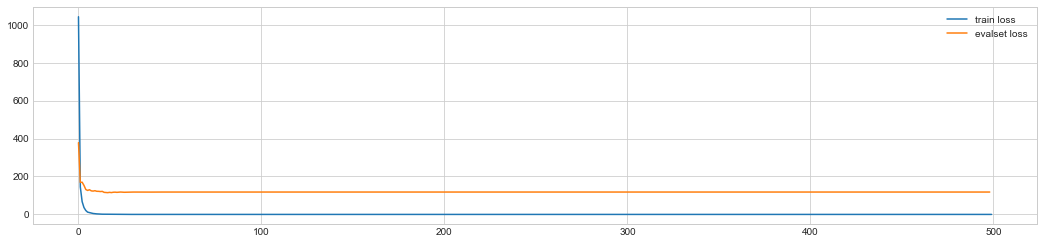

In [25]:
plt.figure(figsize=(18, 4))
plt.plot(gb_regressor.loss_values, label='train loss')
plt.plot(gb_regressor.loss_values_evalset, label='evalset loss')
plt.legend()
plt.show()

На рисунке выше вы должны видеть два графика - лосс на обучающей и на валидационной выборках по итерациям бустинга.

Проверим, что наш бустинг действительно работает: сравним предсказание типа "среднее по датасету" с предсказаниями бустинга для обучающей и валидацонной выборок - после 500 итераций они должны отличаться как минимум в 100 раз.

*Код в ячейках ниже должен выполняться без ошибок.*

In [26]:
# Train
y_mean = np.mean(y_train) * np.ones_like(y_train)
mse_baseline = mean_squared_error(y_train, y_mean)
print('MSE для предсказания среднего по выборке: {:.3f}'.format(mse_baseline))

y_pred = gb_regressor.predict(X_train)
mse_boosting = mean_squared_error(y_train, y_pred)
print('MSE для предсказаний бустинга: {:.3f}'.format(mse_boosting))

np.testing.assert_array_less(mse_boosting, mse_baseline / 100)

MSE для предсказания среднего по выборке: 1648.606
MSE для предсказаний бустинга: 0.081


In [27]:
# Val
y_mean = np.mean(y_val) * np.ones_like(y_val)
mse_baseline = mean_squared_error(y_val, y_mean)
print('MSE для предсказания среднего по выборке: {:.3f}'.format(mse_baseline))

y_pred = gb_regressor.predict(X_val)
mse_boosting = mean_squared_error(y_val, y_pred)
print('MSE для предсказаний бустинга: {:.3f}'.format(mse_boosting))

np.testing.assert_array_less(mse_boosting, mse_baseline / 100)

MSE для предсказания среднего по выборке: 3531.394
MSE для предсказаний бустинга: 0.081


#### 3.2. Задача классификации

In [28]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_repeated=0, n_clusters_per_class=1, flip_y=0.25, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

In [29]:
gb_classifier = GradientBoosting(loss=BCEWithLogitsLoss(), n_estimators=500, learning_rate=1.0, max_depth=3)
gb_classifier.fit(X_train, y_train, X_evalset=X_val, y_evalset=y_val)

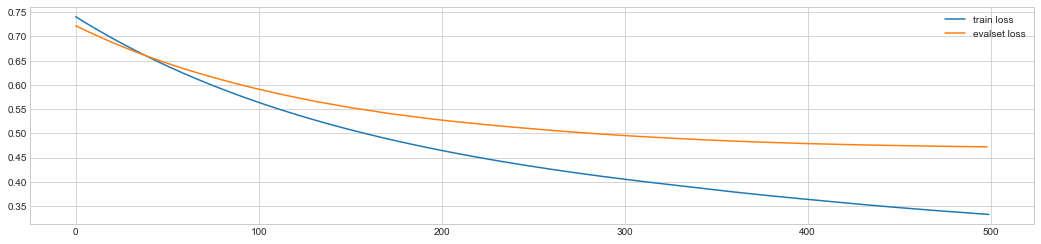

In [30]:
plt.figure(figsize=(18, 4))
plt.plot(gb_classifier.loss_values, label='train loss')
plt.plot(gb_classifier.loss_values_evalset, label='evalset loss')
plt.legend()
plt.show()

На рисунке выше вы должны видеть два графика - лосс на обучающей и на валидационной выборках по итерациям бустинга.

Проверим, что наш бустинг действительно работает: сравним предсказание типа "подбрасывание монетки" с предсказаниями бустинга для обучающей и валидацонной выборок - после 500 итераций ошибка бустинга должна быть как минимум вдвое меньше.

*Код в ячейках ниже должен выполняться без ошибок.*

In [31]:
# Train
y_random = np.random.binomial(1, 0.5, size=len(y_train))
accuracy_baseline = accuracy_score(y_train, y_random)
print('Accuracy для случайного предсказания: {:.3f}'.format(accuracy_baseline))

y_pred = np.array(gb_classifier.predict(X_train) > 0.5, dtype=np.int)
accuracy_boosting = accuracy_score(y_train, y_pred)
print('Accuracy для предсказаний бустинга: {:.3f}'.format(accuracy_boosting))

np.testing.assert_array_less(1 - accuracy_boosting, (1 - accuracy_baseline) / 2 + 1e-5)

Accuracy для случайного предсказания: 0.425
Accuracy для предсказаний бустинга: 0.912


In [32]:
# Val
y_random = np.random.binomial(1, 0.5, size=len(y_val))
accuracy_baseline = accuracy_score(y_val, y_random)
print('Accuracy для случайного предсказания: {:.3f}'.format(accuracy_baseline))

y_pred = np.array(gb_classifier.predict(X_val) > 0.5, dtype=np.int)
accuracy_boosting = accuracy_score(y_val, y_pred)
print('Accuracy для предсказаний бустинга: {:.3f}'.format(accuracy_boosting))

np.testing.assert_array_less(1 - accuracy_boosting, (1 - accuracy_baseline) / 2 + 1e-5)

Accuracy для случайного предсказания: 0.550
Accuracy для предсказаний бустинга: 0.800


Если все тесты пройдены успешно, попробуйте реализовать дополнительный функционал для вашего класса:
- Реализация ранней остановки обучения (1 балл)
- Реализация вычисления дополнительной метрики качества на каждой итерации (1 балл)
- Реализация бэггинга при обучении отдельных деревьев (1 балл)

Для того, чтобы дополнительные баллы были засчитаны, необходимо реализовать функционал и продемонстрировать результат в ячейке внизу.

### MyBoost =  GradientBoosting + R2-score + EarlyStop (with patience)


In [33]:
 class MyBoost(BaseEstimator):
    
    def __init__(self, 
                 loss=None,
                 n_estimators=10, 
                 learning_rate=0.1,
                 max_depth=3,
                 max_features='auto',
                 random_state=2,
                 patience=3,
                 decrease_treshold= 0.9995):
        self.loss = loss
        
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        
        self.max_depth = max_depth
        self.max_features = max_features
        self.patience = patience
        self.decrease_treshold = decrease_treshold
        
        self.estimators = []
        self.loss_values = []
        self.loss_values_evalset = []
        
        self.random_state = random_state
    
    def fit(self, X_train, y_train, X_evalset=[], y_evalset=[], verbose=True): 
        iter_prediction = np.array([y_train.mean() for i in range (len(y_train))])
        iter_loss = self.loss.forward(y_train, iter_prediction)
        self.loss_values.append(iter_loss.sum())
        self.estimators.append(iter_prediction)
        delta_loss = []
        stop_start = max(self.n_estimators * 0.5, self.patience + 1)
        if len(y_evalset) != 0:
            iter_prediction_eval = np.array([y_evalset.mean() for i in range (len(y_evalset))])
        for t in range(1, self.n_estimators):
            antigradient = - self.loss.grad(y_train, iter_prediction)
            tree = DecisionTreeRegressor (max_depth=self.max_depth, \
                                          max_features=self.max_features, \
                                          random_state=self.random_state). \
                                        fit(X_train, antigradient)
            self.estimators.append(tree)
            iter_prediction += self.learning_rate * tree.predict(X_train)
            iter_loss = self.loss.forward(y_train, iter_prediction)
            self.loss_values.append(iter_loss.sum())
            if verbose == True and t % 10 == 0:
                print ('Iter # %s:' %t, 'Loss value: %s' %self.loss_values[-1],  # добавлена R-2 метрика
                       'R2-score: %s' %R2_score(y_train, iter_prediction))
            if len(y_evalset) != 0:
                iter_prediction_eval += tree.predict(X_evalset)
                iter_loss_eval = self.loss.forward(y_evalset, iter_prediction_eval)
                self.loss_values_evalset.append(iter_loss_eval.sum())
                if t % 10 == 0 and verbose == True:
                    print('Loss on evalset: %s' %self.loss_values_evalset[-1], \
                          'R2-score on evalset: %s' %R2_score(y_evalset, iter_prediction_eval))
                if t >= stop_start - self.patience: 
                    delta_loss.append(abs(self.loss_values_evalset[-1] / self.loss_values_evalset[-2]))         #критерий остановки
                if t >= stop_start and all([delta >= self.decrease_treshold for delta in delta_loss[-self.patience:]]):
                    break 
    
    def predict(self, X):
        #prediction = self.estimators[0][:X.shape[0]]
        prediction = np.zeros(X.shape[0])
        for tree in self.estimators[1:]:
            prediction += self.learning_rate * tree.predict(X)
        return prediction


In [34]:
def R2_score (y, y_pred):
    return 1 - ((y - y_pred) ** 2) .sum() / ((y - y.mean()) ** 2) .sum()

In [35]:
R2_score (np.array([1,2]), np.array([2,3] ))

-3.0

## Часть 2. Решение задачи предсказания цены футболиста в FIFA 18 Ultimate Team

Нужно обучить какой-либо из рассмотренных в курсе ансамблей предсказывать трансферную стоимость футболиста из FIFA 18 Ultimate Team. Решение будет оцениваться по метрике MSE на тестовой выборке. Засчитывается только решение, качество которого на тестовой выборке окажется выше, чем у бейзлайна (см. в конце ноутбука).

Данные для обучения - `train_with_targets.csv`, столбец с целевой переменной - `price_ps4`.
Для отправки решения заполните столбец `price_ps4` в файле `test_submission.csv` предсказаниями своей модели на признаках из файла `test.csv` (убедитесь, что порядок следования `player_id` верный).

Для обучения моделей следует использовать:
* \*Свой класс для градиентного бустинга, реализованный выше
* Любые ансамбли из `sklearn` (`RandomForestRegressor`, `GradientBoostingRegressor`, ...)
* Любые фреймворки для градиентного бустинга (`XGBoost`, `LightGBM`, `CatBoost`, ...)
* \*Стекинг/блендинг (свой или тот, что был реализован на лекциях)
* Подбор гиперпараметров с помощью `RandomizedSearch` / `hyperopt` / ... 

Использование пунктов со звездочкой может накинуть дополнительных баллов за задание (по 1 баллу за пункт, т.е. максимум 2 дополнительных балла).

Удачи!

*Ниже приведен пример бейзлайна на случайном лесе из `sklearn`.*

### Baseline на RandomForestClassifier из Sklearn.ensemble

In [36]:
import pandas as pd
data_train = pd.read_csv('./data/train_with_targets.csv')
data_train.head()

,player_ID,player_name,player_extended_name,quality,revision,origin,overall,club,league,nationality,...,cam,cf,rf,lf,rw,lw,st,price_ps4,traits,specialties
0,20920,Sacko,Hadi Sacko,Silver - Rare,Normal,Transfers,68,UD Las Palmas,LaLiga Santander,France,...,65.0,67.0,67.0,67.0,68.0,68.0,66.0,1000.0,"Tries To Beat Defensive Line, Selfish, Dribble...",Speedster
1,2996,Koo Ja Ryong,Ja Ryong Koo,Silver - Rare,Normal,NaN,73,Suwon Samsung Bluewings,K LEAGUE Classic,Korea Republic,...,48.0,46.0,46.0,46.0,46.0,46.0,46.0,450.0,Leadership,NaN
2,12998,Gipson,Ken Gipson,Bronze,Normal,NaN,60,SV Sandhausen,Bundesliga 2,Germany,...,49.0,49.0,49.0,49.0,51.0,51.0,49.0,200.0,NaN,NaN
3,16112,Yoda,Abdoul Karim Yoda,Silver,Normal,Transfers,69,CF Reus,LaLiga 1 I 2 I 3,France,...,66.0,67.0,67.0,67.0,69.0,69.0,65.0,350.0,"Flair, Technical Dribbler",NaN
4,16502,Ronan,Connor Ronan,Bronze - Rare,Normal,Transfers,64,Portsmouth,EFL League One,Republic of Ireland,...,63.0,61.0,61.0,61.0,63.0,63.0,56.0,200.0,NaN,NaN


In [37]:
data_train_num = data_train.select_dtypes(include=['int', 'float'])
data_train_num.fillna(data_train_num.mean(), inplace=True)
data_train_num.head()

/Users/aleksandrkagan/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,player_ID,overall,age,height,weight,intl_rep,pace,pace_acceleration,pace_sprint_speed,dribbling,...,rm,lm,cam,cf,rf,lf,rw,lw,st,price_ps4
0,20920,68,24,183,79,1,91.0,90.0,91.0,69.0,...,67.0,67.0,65.0,67.0,67.0,67.0,68.0,68.0,66.0,1000.0
1,2996,73,26,183,75,1,72.0,69.0,74.0,49.0,...,48.0,48.0,48.0,46.0,46.0,46.0,46.0,46.0,46.0,450.0
2,12998,60,22,178,69,1,76.0,75.0,76.0,55.0,...,52.0,52.0,49.0,49.0,49.0,49.0,51.0,51.0,49.0,200.0
3,16112,69,29,182,73,1,84.0,79.0,88.0,73.0,...,68.0,68.0,66.0,67.0,67.0,67.0,69.0,69.0,65.0,350.0
4,16502,64,20,170,63,1,81.0,80.0,82.0,68.0,...,63.0,63.0,63.0,61.0,61.0,61.0,63.0,63.0,56.0,200.0


In [38]:
from sklearn.model_selection import train_test_split as tts

X = data_train_num.drop(labels=['price_ps4'], axis=1).values[:, 1:]
y = data_train_num['price_ps4'].values
print(X.shape, y.shape)

X_train, X_val, y_train, y_val = tts(X, y, test_size=0.2, random_state=179)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(18629, 64) (18629,)
(14903, 64) (14903,)
(3726, 64) (3726,)


In [39]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, verbose=1, n_jobs=-1, random_state=2)
rf_regressor.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=2, verbose=1, warm_start=False)

In [40]:
rf_regressor_pred = rf_regressor.predict(X_train)
print('train MSE:', mean_squared_error(rf_regressor_pred, y_train))
rf_regressor_pred = rf_regressor.predict(X_val)
print('val MSE:', mean_squared_error(rf_regressor_pred, y_val))

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


train MSE: 442677211.07112485
val MSE: 1075785619.1330426


#### XGBOOST library

In [41]:
from xgboost import XGBRegressor

In [42]:
xgb_regressor = XGBRegressor(n_estimators=400, max_depth = 3)
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [43]:
xgb_regressor_pred = xgb_regressor.predict(X_train)
print('train MSE:', mean_squared_error(xgb_regressor_pred, y_train))
xgb_regressor_pred = xgb_regressor.predict(X_val)
print('val MSE:', mean_squared_error(xgb_regressor_pred, y_val))

train MSE: 56354668.77023895
val MSE: 678222891.6151305


In [44]:
print(mean_squared_error(xgb_regressor_pred, y_val) / mean_squared_error(rf_regressor_pred, y_val))

0.6304442814189122


### MyBoost

In [45]:
boost = MyBoost(loss = MSELoss(), n_estimators = 400, learning_rate = 0.08, max_depth = 2, patience = 10)

In [46]:
boost.fit(X_train, y_train, X_evalset = X_val, y_evalset = y_val, verbose=True)

Iter # 10: Loss value: 2508348317.8777065 R2-score: 0.5673170673252816
Loss on evalset: 123677861812.57959 R2-score on evalset: -17.49341184983749
Iter # 20: Loss value: 1423724409.4447322 R2-score: 0.7544115988961457
Loss on evalset: 297451465559.1633 R2-score on evalset: -43.47758375916432
Iter # 30: Loss value: 978210069.0421102 R2-score: 0.8312615523017984
Loss on evalset: 445730459224.3233 R2-score on evalset: -65.64957524042656
Iter # 40: Loss value: 767666736.8330663 R2-score: 0.8675796767767894
Loss on evalset: 556881374666.6681 R2-score on evalset: -82.26984686087812
Iter # 50: Loss value: 639204828.725987 R2-score: 0.8897389896364125
Loss on evalset: 623038274047.124 R2-score on evalset: -92.1622137648683
Iter # 60: Loss value: 540815617.3587542 R2-score: 0.9067108480559586
Loss on evalset: 674196662927.7417 R2-score on evalset: -99.81187022947557
Iter # 70: Loss value: 480987437.491092 R2-score: 0.9170310384925217
Loss on evalset: 702446629948.6797 R2-score on evalset: -104.

In [47]:
myboost_pred = boost.predict(X_train)
print('train MSE:', mean_squared_error(myboost_pred, y_train))
myboost_pred = boost.predict(X_val)
print('val MSE:', mean_squared_error(myboost_pred, y_val))

train MSE: 592367214.2146995
val MSE: 1154662873.4741354


In [48]:
print(mean_squared_error(myboost_pred, y_val) / mean_squared_error(rf_regressor_pred, y_val))

1.0733206067623944


### Catboost

In [49]:
from catboost import CatBoostRegressor

In [50]:
catboost = CatBoostRegressor(iterations = 400, depth=3)

In [51]:
catboost.fit(X_train, y_train)

0:	learn: 106861.8391752	total: 74.9ms	remaining: 29.9s
1:	learn: 105798.3704074	total: 94.1ms	remaining: 18.7s
2:	learn: 104335.5514595	total: 104ms	remaining: 13.8s
3:	learn: 103000.3428721	total: 113ms	remaining: 11.2s
4:	learn: 101506.0822534	total: 124ms	remaining: 9.8s
5:	learn: 100020.3043489	total: 136ms	remaining: 8.94s
6:	learn: 98661.9438273	total: 145ms	remaining: 8.13s
7:	learn: 97272.4114258	total: 153ms	remaining: 7.5s
8:	learn: 95967.3003799	total: 162ms	remaining: 7.02s
9:	learn: 94736.1434176	total: 171ms	remaining: 6.69s
10:	learn: 93540.2945732	total: 184ms	remaining: 6.5s
11:	learn: 92331.5302411	total: 191ms	remaining: 6.17s
12:	learn: 91232.2767075	total: 202ms	remaining: 6.01s
13:	learn: 90057.7880362	total: 212ms	remaining: 5.83s
14:	learn: 89068.3553024	total: 220ms	remaining: 5.63s
15:	learn: 87976.3631326	total: 230ms	remaining: 5.53s
16:	learn: 87024.2613631	total: 238ms	remaining: 5.36s
17:	learn: 85993.8532618	total: 250ms	remaining: 5.29s
18:	learn: 8484

157:	learn: 39552.8830277	total: 1.72s	remaining: 2.64s
158:	learn: 39536.6158411	total: 1.74s	remaining: 2.64s
159:	learn: 39485.6076751	total: 1.76s	remaining: 2.64s
160:	learn: 39381.9289198	total: 1.78s	remaining: 2.64s
161:	learn: 39345.8457868	total: 1.79s	remaining: 2.63s
162:	learn: 39193.4427615	total: 1.81s	remaining: 2.63s
163:	learn: 39116.7646885	total: 1.82s	remaining: 2.62s
164:	learn: 39047.6542380	total: 1.83s	remaining: 2.6s
165:	learn: 38975.8987911	total: 1.84s	remaining: 2.59s
166:	learn: 38845.0921987	total: 1.86s	remaining: 2.59s
167:	learn: 38703.9449435	total: 1.87s	remaining: 2.59s
168:	learn: 38694.1446956	total: 1.89s	remaining: 2.58s
169:	learn: 38595.1103101	total: 1.91s	remaining: 2.58s
170:	learn: 38549.5007286	total: 1.92s	remaining: 2.57s
171:	learn: 38513.3951060	total: 1.94s	remaining: 2.57s
172:	learn: 38401.8130608	total: 1.96s	remaining: 2.57s
173:	learn: 38321.9577738	total: 1.97s	remaining: 2.56s
174:	learn: 38278.6208298	total: 2s	remaining: 2.

318:	learn: 32923.2662552	total: 3.79s	remaining: 961ms
319:	learn: 32917.1286797	total: 3.79s	remaining: 949ms
320:	learn: 32884.3884600	total: 3.8s	remaining: 935ms
321:	learn: 32874.0570320	total: 3.81s	remaining: 922ms
322:	learn: 32860.9869368	total: 3.81s	remaining: 909ms
323:	learn: 32793.2893913	total: 3.82s	remaining: 896ms
324:	learn: 32790.0080991	total: 3.83s	remaining: 883ms
325:	learn: 32786.6077641	total: 3.83s	remaining: 870ms
326:	learn: 32782.6943414	total: 3.84s	remaining: 857ms
327:	learn: 32727.7775562	total: 3.85s	remaining: 844ms
328:	learn: 32725.1854958	total: 3.85s	remaining: 832ms
329:	learn: 32708.4919192	total: 3.86s	remaining: 819ms
330:	learn: 32705.0870372	total: 3.87s	remaining: 806ms
331:	learn: 32651.1788206	total: 3.87s	remaining: 793ms
332:	learn: 32646.8757478	total: 3.88s	remaining: 781ms
333:	learn: 32635.8551469	total: 3.88s	remaining: 768ms
334:	learn: 32631.1582433	total: 3.89s	remaining: 755ms
335:	learn: 32620.4754699	total: 3.9s	remaining: 

In [52]:
catboost_pred = catboost.predict(X_train)
print('train MSE:', mean_squared_error(catboost_pred, y_train))
catboost_pred = catboost.predict(X_val)
print('val MSE:', mean_squared_error(catboost_pred, y_val))

train MSE: 995825210.4877136
val MSE: 782900887.313009


In [53]:
print(mean_squared_error(catboost_pred, y_val) / mean_squared_error(rf_regressor_pred, y_val))

0.7277480507165875


### Ensemble


In [54]:
def split_data (k, X):
    n = X.shape[0] 
    split_X = [X[(n//k)*i : (n//k)*(i+1)] for i in range (0, k-n%k)]
    a = (k-n%k) * (n//k)
    for i in range (0, n%k):
        split_X.append(X[a+i*(n-a)//(n%k): a+(i+1)*(n-a)//(n%k)])
    return split_X

In [55]:
def remove(List,i):
    return List[:i] + List[i+1:]

In [56]:
X = np.array([[1,2],[2,3],[3,4]])
split_data (2, X)

[array([[1, 2]]), array([[2, 3],
        [3, 4]])]

In [57]:
from sklearn.linear_model import LinearRegression

In [58]:
def weighted_pred (predictions_ensemble, y_true, metric=mean_squared_error, less_better=True):
    weighted_prediction = np.zeros(len(y_val))
    prediction_metric = []
    if less_better:
        for prediction in predictions_ensemble:
            prediction_metric.append(1 / metric(prediction, y_true))
            weighted_prediction += np.array(prediction) * prediction_metric[-1]
    else:
        for prediction in predictions_ensemble:
            prediction_metric.append(metric(prediction, y_true))
            weighted_prediction += np.array(prediction) * prediction_metric[-1]
    return weighted_prediction / sum(prediction_metric), np.array(prediction_metric) / sum(prediction_metric)

def MyEnsemble_predict (Ensemble, X_val, y_val,metric=mean_squared_error, less_better=True):
    predictions_ensemble = []
    for i, boost in enumerate(Ensemble):
        predictions_ensemble.append(boost.predict (X_val))
    return weighted_pred(predictions_ensemble, y_val, metric=metric, less_better=less_better)

In [59]:
def find_weights (FINAL_STACK, y, metric=mean_squared_error, less_better=True, step=0.001,iterations=500):
    weights = np.array([1/len(FINAL_STACK) for i in range (len(FINAL_STACK))])
    result =  metric (y, np.array(FINAL_STACK).T.dot(weights)) 
    sum_koef = sum(weights)
    for i in range (iterations):
        for j in range (len(FINAL_STACK)):
            weights[j] += step
            iter_res_p = metric (y, np.array(FINAL_STACK).T.dot(weights) / (sum_koef + step))
            if (iter_res_p > result and less_better==True) or (iter_res_p < result and less_better==False):
                weights[j] -= 2 * step
                iter_res_n = metric (y, np.array(FINAL_STACK).T.dot(np.array(weights)) / (sum_koef - step))
                if (iter_res_n < result and less_better==True) or (iter_res_n > result and less_better==False):
                    result = iter_res_n 
                    sum_koef -= step
                else:
                    weights[j] += step
            else: 
                result = iter_res_p 
                sum_koef += step
                
    return np.array(FINAL_STACK).T.dot(weights) / sum_koef, weights / sum(weights)

In [60]:
def stacking (MyEnsemble, n, X_train, X_test, y_train, fit=False): #n - number of folds
    split_X = split_data (n, X_train)
    split_y = split_data (n, y_train)
    A_meta = []
    T_meta = []
    for model in MyEnsemble:
        if fit == True:
            model.fit(X_train, y_train)
        T_meta.append(np.array(model.predict(X_test)))
    for i in range (n):
        X_pred = split_X[i]
        X_iter = np.concatenate(remove(split_X, i))
        y_iter = np.concatenate(remove(split_y, i))
        A_meta_iter=[]
        for model in MyEnsemble:
            if fit == True:
                model.fit(X_iter, y_iter)
            A_meta_iter.append(np.array(model.predict(X_pred)))
        A_meta_iter = np.vstack(A_meta_iter).T
        A_meta.append(A_meta_iter)
    A_meta = np.vstack(A_meta)
    T_meta = np.vstack(T_meta).T
    LR = LinearRegression(normalize=True)
    LR.fit(A_meta, y_train)
    return LR.predict(T_meta)

In [61]:
MyEnsemble = [boost, rf_regressor, xgb_regressor, catboost]

In [62]:
Stack_pred = stacking (MyEnsemble, 3, X_train, X_val, y_train)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [63]:
print(mean_squared_error(Stack_pred, y_val) / mean_squared_error(rf_regressor_pred, y_val))

0.6226769748169668


In [64]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import explained_variance_score as EVS

In [65]:
final_prediction_1 = MyEnsemble_predict (MyEnsemble, X_val, y_val, metric=mean_squared_error)
final_prediction_2 = MyEnsemble_predict (MyEnsemble, X_val, y_val, metric=MAE)
final_prediction_3 = MyEnsemble_predict (MyEnsemble, X_val, y_val, metric=EVS, less_better=False)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [66]:
FINAL_STACK = [Stack_pred, final_prediction_1[0], final_prediction_3[0], final_prediction_2[0]]

In [67]:
FINAL_PREDICT = find_weights(FINAL_STACK, y_val, metric=mean_squared_error, less_better=True, step=0.0001,iterations=10000)

In [68]:
FINAL_PREDICT[1]

array([-0.08108108, 12.22245322, -9.40540541, -1.73596674])

In [69]:
print(mean_squared_error(FINAL_PREDICT[0], y_val) / mean_squared_error(rf_regressor_pred, y_val))

0.526471934393903


## Тестирование:

In [70]:
from sklearn.metrics import mean_squared_error 

In [71]:
df = pd.read_csv('./data/test.csv')
test = df.copy()

In [72]:
test_num = test.select_dtypes(include=['int', 'float'])
X_test = np.array(test_num.fillna(test_num.mean(), inplace=True).drop(labels=['player_ID'], axis=1))

/Users/aleksandrkagan/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [73]:
Predictions = [model.predict(X_test) for model in MyEnsemble]

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [74]:
Stack_pred_test = stacking (MyEnsemble, 3, X_train, X_test, y_train)
test_answers1 = np.dot(final_prediction_1[1], Predictions)
test_answers2 = np.dot(final_prediction_2[1], Predictions)
test_answers3 = np.dot(final_prediction_3[1], Predictions)
Final_answers = [Stack_pred_test, test_answers1, test_answers2, test_answers3]

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [75]:
final_prediction_test = np.dot(FINAL_PREDICT[1], Final_answers)

In [76]:
submission = pd.concat((test['player_ID'], pd.Series(final_prediction_test )), axis = 1)

In [77]:
submission.to_csv('./data/test_submission.csv', index=False)

In [78]:
my_submission = pd.read_csv('./data/test_submission.csv')

In [79]:
my_submission.head()

,player_ID,0
0,9991,-8033.111034
1,13037,-10852.444449
2,1254,-7540.611491
3,19697,-11382.711132
4,12390,-11031.735527


In [80]:
my_submission = pd.read_csv('./data/test_submission.csv')
true_submssion = pd.read_csv('./data/test_submission.csv')

In [81]:
assert sum(my_submission['player_ID'].values != true_submssion['player_ID'].values) == 0

In [341]:
mse = mean_squared_error(my_submission['player_ID'], true_submssion['player_ID'])
print(mse)

0.0
